In [1]:
import os
from pathlib import Path
compe='spooky-author-identification'
is_kaggle=os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if is_kaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{compe}.zip').extractall(path)

In [3]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
os.listdir('spooky-author-identification')

['test.zip', 'sample_submission.zip', 'train.zip']

In [5]:
df=pd.read_csv(f'{compe}/train.zip')
df_test=pd.read_csv(f'{compe}/test.zip')
df_sub=pd.read_csv(f'{compe}/sample_submission.zip')
df.shape,df_test.shape

((19579, 3), (8392, 2))

In [5]:
df.head(4)

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS


In [6]:
df_sub.head(2)

,id,EAP,HPL,MWS
0,id02310,0.40,0.29,0.31
1,id24541,0.40,0.29,0.31


### EDA

In [7]:
df.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

> So basically its multi class classification pblm - (classes=3)

In [8]:
df['text'].describe()

count                                                                                                                                                                                                                                       19579
unique                                                                                                                                                                                                                                      19579
top       This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
freq                                                                                                                                                                                                                                            1
Name: text, dtype: object

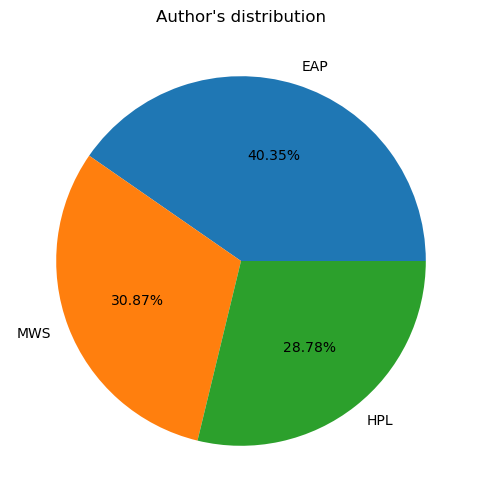

Shape is  (19579, 3)


In [20]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,1,figsize=(10,6))
text_author_counts = df['author'].value_counts()
axs.pie(text_author_counts, labels=text_author_counts.index, autopct='%1.2f%%')
axs.set_title("Author's distribution")
plt.show()
print('Shape is ',df.shape)

In [11]:
text_author_counts = df['author'].value_counts()
text_author_counts

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [22]:
byAuthor = df.groupby("author")


,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL
5,id22965,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",MWS


In [59]:
df.groupby("author").size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

In [60]:
import nltk

In [61]:
byAuthor=df.groupby('author')
wordFreqByAuthor = nltk.probability.ConditionalFreqDist()

In [75]:
for name,group in byAuthor:
    sentences=group['text'].str.cat(sep=' ')
    sentences=sentences.lower()
    tokens=nltk.tokenize.word_tokenize(sentences)
    frequency = nltk.FreqDist(tokens)
    wordFreqByAuthor[name] = (frequency)
#     print(frequency)
#     break


In [77]:
wordFreqByAuthor['EAP']

FreqDist({',': 17594, 'the': 14969, 'of': 8970, '.': 7634, 'and': 5733, 'to': 4761, 'a': 4711, 'in': 4124, 'i': 3780, 'that': 2327, ...})

In [80]:
wordFreqByAuthor['EAP'].freq(',')

0.07581137213671384

In [ ]:
testSentence = "It was a dark and stormy night."
testSentence=testSentence.lower()
testSentence_processed=nltk.tokenize.word_tokenize(sentences)

### Model Preparation

In [16]:
df.author.values[:10]

array(['EAP', 'HPL', 'EAP', 'MWS', 'HPL', 'MWS', 'EAP', 'EAP', 'EAP',
       'MWS'], dtype=object)

In [18]:
from sklearn import preprocessing,model_selection

lbl_encoder=preprocessing.LabelEncoder()
y=lbl_encoder.fit_transform(df.author.values)
y[:10]

array([0, 1, 0, 2, 1, 2, 0, 0, 0, 2])

In [24]:
xtrain,xvalid,ytrain,yvalid=model_selection.train_test_split(df.text.values,y,stratify=y,test_size=0.1,
                                                             shuffle=True,random_state=42)
print('shape of xtrain:',xtrain.shape)
print('shape of xvalid:',xvalid.shape)

shape of xtrain: (17621,)
shape of xvalid: (1958,)


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfv=TfidfVectorizer(max_df=3,max_features=None,strip_accents='unicode',analyzer='word',
                    token_pattern=r'\w{1,}',ngram_range=(1, 3),use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words='english')

In [33]:
tfv.fit(list(xtrain)+list(xvalid))

TfidfVectorizer(max_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [34]:
xtrain_tfv=tfv.transform(xtrain)
xvalid_tfv=tfv.transform(xvalid)

In [39]:
xvalid_tfv

<1958x389110 sparse matrix of type '<class 'numpy.float64'>'
	with 41812 stored elements in Compressed Sparse Row format>

In [50]:
models={'lr':{'model':'','preds':[]}}

In [64]:
from sklearn.linear_model import LogisticRegression

model_lr=LogisticRegression(C=1.0)
models['lr']['model']=model_lr

model_lr.fit(xtrain_tfv,ytrain)
preds_lr=model_lr.predict_proba(xvalid_tfv)
models['lr']['preds']=preds_lr
preds_lr

array([[0.43020151, 0.27400766, 0.29579083],
       [0.40442556, 0.29544725, 0.30012719],
       [0.40945443, 0.28641328, 0.3041323 ],
       ...,
       [0.40639986, 0.28510631, 0.30849382],
       [0.39837113, 0.29785823, 0.30377064],
       [0.39513219, 0.29021375, 0.31465406]])

In [65]:
print('Xvalid for - Logistic regression',muti_class_loss(yvalid,preds_lr))

Xvalid for - Logistic regression 1.0661543851415116


In [66]:
ctv=CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

In [67]:
ctv.fit(list(xtrain)+list(xvalid))
xtrain_ctv=ctv.transform(xtrain)
xvalid_ctv=ctv.transform(xvalid)
print('Shape of xtrain',xtrain_ctv.shape)
print('Shape of xvalid',xvalid_ctv.shape)

Shape of xtrain (17621, 400266)
Shape of xvalid (1958, 400266)


In [69]:
model_lr_ctv=LogisticRegression(C=1.0)
models['lr']['model']=model_lr_ctv

model_lr_ctv.fit(xtrain_ctv,ytrain)
preds_lr_ctv=model_lr_ctv.predict_proba(xvalid_ctv)
models['lr']['preds']=preds_lr_ctv
preds_lr_ctv

/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[7.70832283e-01, 1.65960394e-02, 2.12571677e-01],
       [9.02504812e-01, 3.32705140e-02, 6.42246738e-02],
       [7.90067358e-01, 1.06516213e-01, 1.03416429e-01],
       ...,
       [3.70006118e-01, 1.83420655e-01, 4.46573227e-01],
       [1.35184911e-01, 6.35601687e-02, 8.01254920e-01],
       [1.57126731e-04, 9.99824862e-01, 1.80113606e-05]])

In [70]:
print('Xvalid for - Logistic regression',muti_class_loss(yvalid,preds_lr_ctv))

Xvalid for - Logistic regression 0.526574671995379


In [71]:
preds_lr_ctv.round(2)

array([[0.77, 0.02, 0.21],
       [0.9 , 0.03, 0.06],
       [0.79, 0.11, 0.1 ],
       ...,
       [0.37, 0.18, 0.45],
       [0.14, 0.06, 0.8 ],
       [0.  , 1.  , 0.  ]])

In [84]:
models

{'lr': {'model': LogisticRegression(),
  'preds': array([[7.70832283e-01, 1.65960394e-02, 2.12571677e-01],
         [9.02504812e-01, 3.32705140e-02, 6.42246738e-02],
         [7.90067358e-01, 1.06516213e-01, 1.03416429e-01],
         ...,
         [3.70006118e-01, 1.83420655e-01, 4.46573227e-01],
         [1.35184911e-01, 6.35601687e-02, 8.01254920e-01],
         [1.57126731e-04, 9.99824862e-01, 1.80113606e-05]])}}

#### Xgb classifier

In [85]:
new_item = {'model': '', 'preds': []}
models['xgb']=new_item

In [86]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
models['xgb']['model']=xgb_clf

In [87]:
xgb_clf.fit(xtrain_ctv,ytrain)
preds_xgb=xgb_clf.predict_proba(xvalid_ctv)
models['xgb']['preds']=preds_xgb
preds_xgb

array([[0.4819386 , 0.16739263, 0.35066873],
       [0.4983455 , 0.2376007 , 0.26405385],
       [0.5586272 , 0.20904921, 0.2323236 ],
       ...,
       [0.48249033, 0.24126275, 0.2762469 ],
       [0.42294136, 0.244047  , 0.33301163],
       [0.2224112 , 0.6635582 , 0.11403061]], dtype=float32)

In [88]:
print('Xvalid for - Logistic regression',muti_class_loss(yvalid,preds_xgb))

Xvalid for - Logistic regression 0.7719998405045289


In [91]:
new_item = {'model': '', 'preds': []}
models['rf']=new_item

In [97]:
from sklearn.ensemble import RandomForestRegressor
rf_clf = RandomForestRegressor()
models['rf']['model']=rf_clf
rf_clf

RandomForestRegressor()

In [98]:
rf_clf.fit(xtrain_ctv,ytrain)
preds_rf=rf_clf.predict_proba(xvalid_ctv)
models['rf']['preds']=preds_rf
preds_rf

KeyboardInterrupt: 

In [99]:
print('Xvalid for - Randomfrorest classifier',muti_class_loss(yvalid,preds_rf))

Xvalid for - Randomfrorest classifier 0.7611970797243176


### Glove text Embedding

In [107]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [104]:
from tqdm import tqdm
embeddings_index = {}
f = open('/Volumes/TAPPS/Glo/glove.6B/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:20, 19703.63it/s]


In [ ]:
embeddings_index

In [119]:
from nltk import word_tokenize
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [226]:
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove=[sent2vec(x) for x in tqdm(xvalid)]
xtest_glove=[sent2vec(x) for x in tqdm(df_test.text.values)]

100%|█████████████████████████████████████| 8392/8392 [00:01<00:00, 4913.72it/s]


In [227]:
xtrain_glove=np.array(xtrain_glove)
xvalid_glove=np.array(xvalid_glove)
xtest_glove=np.array(xtest_glove)


In [127]:
clf=XGBClassifier()
clf.fit(xtrain_glove,ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [132]:
preds=clf.predict_proba(xvalid_glove)

In [133]:
muti_class_loss(yvalid,preds)

0.7849370234608327

In [128]:
xgb_clf=XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

In [129]:
xgb_clf.fit(xtrain_glove,ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [130]:
preds=xgb_clf.predict_proba(xvalid_glove)

In [131]:
muti_class_loss(yvalid,preds)

0.7620828963054651

In [136]:
xtrain_glove.shape

(17621, 300)

#### Neural nets with Glove

In [216]:
import torch
from torch import nn
device='cpu'

In [243]:
class GloveNN(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_stack(x)

model_nn = GloveNN(input_features=300, output_features=3, hidden_units=16).to(device)


In [244]:
model_nn

GloveNN(
  (linear_stack): Sequential(
    (0): Linear(in_features=300, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [245]:
xtrain_glove_tn=torch.tensor(xtrain_glove).to(torch.float32)
xvalid_glove_tn=torch.tensor(xvalid_glove).to(torch.float32)
xtest_glove_tn=torch.tensor(xtest_glove).to(torch.float32)
yvalid_glove_tn=torch.tensor(yvalid).long()
ytrain_glove_tn=torch.tensor(ytrain).long()

yvalid_glove_tn.dtype,xtrain_glove_tn.shape

(torch.int64, torch.Size([17621, 300]))

In [246]:
y_logits=model_nn(xtrain_glove_tn)
y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred[:5]

tensor([0, 0, 2, 2, 2])

In [247]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_nn.parameters(),lr=0.1)

In [248]:
EPOCHS=1000
for epoch in range(EPOCHS):
    model_nn.train()
    pred_l=model_nn(xtrain_glove_tn)
    pred_t=torch.softmax(pred_l,dim=1).argmax(dim=1)
    acc=accuracy_fn(ytrain_glove_tn,pred_t)
    loss=loss_fn(pred_l,ytrain_glove_tn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch%100==0):
        model_nn.eval()
        with torch.inference_mode():
            pred_lt=model_nn(xvalid_glove_tn)
        losst=loss_fn(pred_lt,yvalid_glove_tn)
        pred_tt=torch.softmax(pred_lt,dim=1).argmax(dim=1)
        acct=accuracy_fn(yvalid_glove_tn,pred_tt)
        print(f'Train Loss: {loss}, Train Acc:{acc} | Test Loss:{losst}, Test Accuracy{acct}')
        

Train Loss: 1.15372896194458, Train Acc:32.39316724362976 | Test Loss:1.112688660621643, Test Accuracy30.847803881511748
Train Loss: 0.7202520370483398, Train Acc:68.98586913342035 | Test Loss:0.7927851676940918, Test Accuracy66.7517875383044
Train Loss: 0.656692385673523, Train Acc:72.17524544577493 | Test Loss:0.7788841724395752, Test Accuracy65.37282941777323
Train Loss: 0.6122264862060547, Train Acc:74.34311333068497 | Test Loss:0.821290910243988, Test Accuracy64.40245148110317
Train Loss: 0.5839310884475708, Train Acc:75.47244764769309 | Test Loss:0.8402340412139893, Test Accuracy64.75995914198161
Train Loss: 0.5605775713920593, Train Acc:76.6017819647012 | Test Loss:0.8718090653419495, Test Accuracy64.19816138917263
Train Loss: 0.5400409698486328, Train Acc:77.60626525168833 | Test Loss:0.9321956038475037, Test Accuracy62.7170582226762
Train Loss: 0.5255682468414307, Train Acc:78.41779694682481 | Test Loss:0.9599264860153198, Test Accuracy63.84065372829418
Train Loss: 0.511833727

In [249]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=correct*100/len(y_true)
    return acc

In [250]:
accuracy_fn(y_pred,ytrain_glove_tn)

32.39316724362976

In [251]:
xtrain_glove_tn.shape,ytrain_glove_tn.shape

(torch.Size([17621, 300]), torch.Size([17621]))

In [252]:
with torch.inference_mode():
    pred_lt=model_nn(xtest_glove_tn)
pred_tt=torch.softmax(pred_lt,dim=1).argmax(dim=1)
output=pred_lt.numpy().round(2)

In [253]:
pred_probabilities = np.exp(output) / np.sum(np.exp(output), axis=1, keepdims=True)
pred_y=pred_probabilities.round(2)

In [254]:
make_sub(pred_y,name='nn_with_glove_nn2')

100%|██████████| 184k/184k [00:00<00:00, 271kB/s]  


Successfully submitted to Spooky Author IdentificationSuccessfully saved - nn_with_glove_nn2 at Submissions/sub-nn_with_glove_nn2.csv


### Model Testing loss

In [58]:
def muti_class_loss(actual,predicted,eps=1e-15):
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota


### Predicting for Test Set

In [77]:
xtest_ctv=ctv.transform(df_test.text.values)
xtest_ctv

<8392x400266 sparse matrix of type '<class 'numpy.int64'>'
	with 105020 stored elements in Compressed Sparse Row format>

In [81]:
pred_test_ctv.shape

(8392, 3)

In [83]:
pred_test_ctv=model_lr_ctv.predict_proba(xtest_ctv).round(2)
pred_test_ctv
make_sub(pred_test_ctv,name='lr_ctv')

100%|██████████| 184k/184k [00:01<00:00, 182kB/s]  


Successfully submitted to Spooky Author IdentificationSuccessfully saved - lr_ctv at Submissions/sub-lr_ctv.csv


In [238]:
pred_test_ctv

array([[0.18, 0.03, 0.79],
       [0.94, 0.05, 0.01],
       [0.31, 0.67, 0.01],
       ...,
       [0.97, 0.02, 0.02],
       [0.06, 0.  , 0.94],
       [0.38, 0.61, 0.01]])

### Submission

In [82]:
import subprocess
import os

def make_sub(pred_y, sub_data=df_test, name='default'):
    df_submission = pd.DataFrame()
    df_submission['id'] = df_test['id']
    df_submission[['EAP','HPL','MWS']] = pred_y    
    
    folder_path = 'Submissions/'
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist
    
    file_path = os.path.join(folder_path, f'sub-{name}.csv')
    df_submission.to_csv(file_path, index=False)
    
    cmd = f'kaggle competitions submit -c {compe} -f {file_path} -m "Message"'
    subprocess.run(cmd, shell=True)
    
    print(f'Successfully saved - {name} at {file_path}')


In [12]:
preds_y1=[0.33]*len(df_test)
preds_y2=preds_y1
preds_y3=preds_y1
make_sub(preds_y1,preds_y2,preds_y3,name='dum_model')

100%|██████████| 189k/189k [00:01<00:00, 189kB/s]  


Successfully submitted to Spooky Author IdentificationSuccessfully saved - dum_model at Submissions/sub-dum_model.csv


In [237]:
pred_y

NameError: name 'pred_y' is not defined